In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [128]:
df = pd.read_csv("optdigits.tra", header=None, sep=",")
df.to_csv("output_file.csv", index=False)
n_cols = df.shape[1]
X = df.iloc[:, :n_cols-1]
y = df.iloc[:, n_cols-1].astype(int)

In [129]:
df.shape

(3823, 65)

In [130]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,0,1,6,15,12,1,0,0,0,7,...,0,0,0,6,14,7,1,0,0,0
1,0,0,10,16,6,0,0,0,0,7,...,0,0,0,10,16,15,3,0,0,0
2,0,0,8,15,16,13,0,0,0,1,...,0,0,0,9,14,0,0,0,0,7
3,0,0,0,3,11,16,0,0,0,0,...,0,0,0,0,1,15,2,0,0,4
4,0,0,5,14,4,0,0,0,0,0,...,0,0,0,4,12,14,7,0,0,6


In [131]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [132]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
cumulative = np.cumsum(PCA().fit(X_train_scaled).explained_variance_ratio_)
n_components_95 = np.searchsorted(cumulative, 0.95) +1
n_components_30 = min(30, X_train.shape[1])
print(f"PCA components to retain 95% variance: {n_components_95}")

PCA components to retain 95% variance: 41


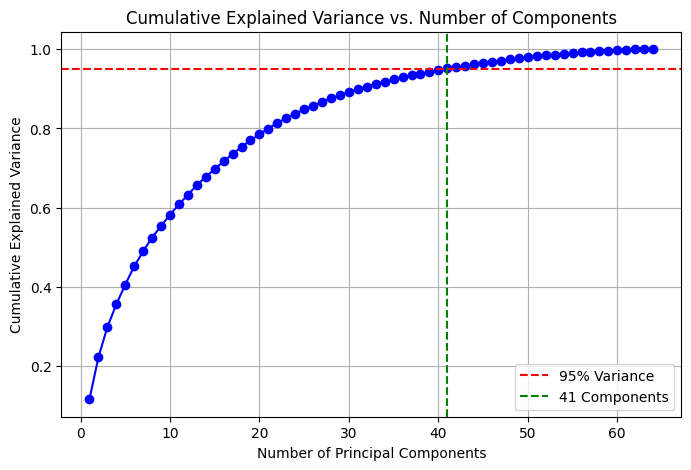

In [133]:
plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative) + 1), cumulative, marker='o', linestyle='-', color='b')
plt.axhline(y=0.95, color='r', linestyle='--', label='95% Variance')
plt.axvline(x=n_components_95, color='g', linestyle='--', label=f'{n_components_95} Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.legend()
plt.grid(True)
plt.show()

In [134]:
models = {
    "LogisticRegression": LogisticRegression(max_iter=400, solver="saga", multi_class="multinomial", random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=50, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5)
}

In [135]:
results = []
for name, model in models.items():
    print(f"\n🔹 Training {name} ...")

    pipe95 = Pipeline([
        ("sc", StandardScaler()),
        ("pca", PCA(n_components=n_components_95, random_state=42)),
        ("clf", model)
    ])
    pipe95.fit(X_train, y_train)
    acc95 = accuracy_score(y_test, pipe95.predict(X_test))

    pipe30 = Pipeline([
        ("sc", StandardScaler()),
        ("pca", PCA(n_components=n_components_30, random_state=42)),
        ("clf", model)
    ])
    pipe30.fit(X_train, y_train)
    acc30 = accuracy_score(y_test, pipe30.predict(X_test))

    results.append({
        "Model": name,
        "Test_Acc_PCA95": acc95,
        "Test_Acc_PCA30": acc30
    })

res_df = pd.DataFrame(results).sort_values(by="Test_Acc_PCA95", ascending=False).reset_index(drop=True)
print("\nModel Comparison:\n", res_df)


🔹 Training LogisticRegression ...


C:\Users\Nandhakumar\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Nandhakumar\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Nandhakumar\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\Nandhakumar\AppData\Roaming\Python\Python313\site-packages\sklearn\linear_model\_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ di


🔹 Training RandomForest ...

🔹 Training KNN ...

Model Comparison:
                 Model  Test_Acc_PCA95  Test_Acc_PCA30
0                 KNN        0.980392        0.976471
1        RandomForest        0.968627        0.971242
2  LogisticRegression        0.962092        0.960784


In [136]:
best_model_name = res_df.iloc[0]["Model"]
print(f"\nBest Model: {best_model_name}")

best_model = models[best_model_name]
best_pipe = Pipeline([
    ("sc", StandardScaler()),
    ("pca", PCA(n_components=n_components_95, random_state=42)),
    ("clf", best_model)
])
best_pipe.fit(X_train, y_train)

y_pred = best_pipe.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print(f"Final Accuracy (PCA95): {acc:.4f}")


Best Model: KNN
Final Accuracy (PCA95): 0.9804


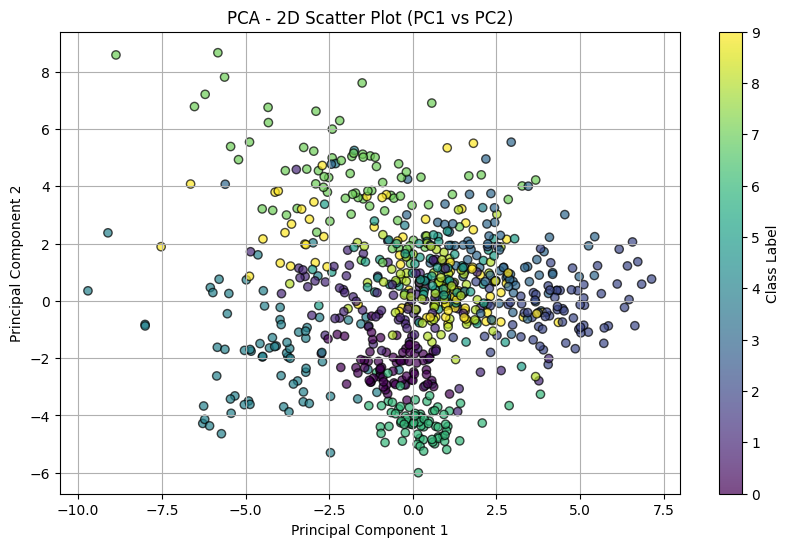

In [137]:
pca_step = best_pipe.named_steps["pca"]
scaler_in_pipe = best_pipe.named_steps["sc"]
X_test_scaled = scaler_in_pipe.transform(X_test)
X_test_pca = pca_step.transform(X_test_scaled)

plt.figure(figsize=(10,6))
scatter = plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_test, cmap='viridis', alpha=0.7, edgecolors='k')
plt.title("PCA - 2D Scatter Plot (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(scatter, label="Class Label")
plt.grid(True)
plt.show()


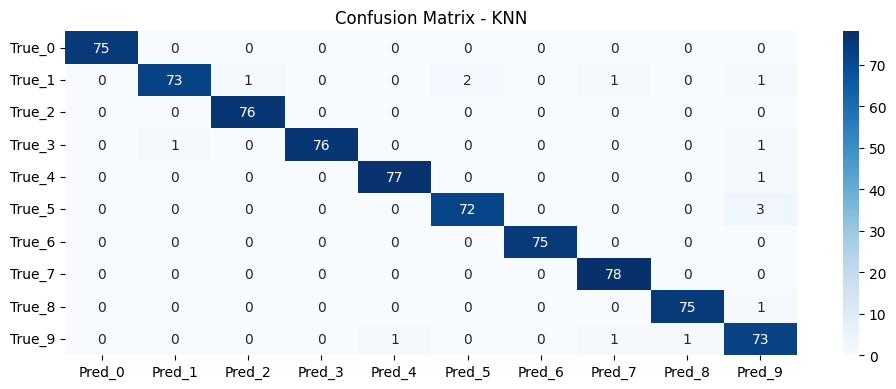

In [138]:
report_df = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()

unique_labels = np.unique(np.concatenate([y_test, y_pred]))
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
cm_df = pd.DataFrame(
    cm,
    index=[f"True_{i}" for i in unique_labels],
    columns=[f"Pred_{i}" for i in unique_labels]
)

plt.figure(figsize=(10, 4))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title(f"Confusion Matrix - {best_model_name}")
plt.tight_layout()
plt.show()

In [139]:
import pickle
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA(n_components=n_components_95)),  # 95% variance
    ('knn', KNeighborsClassifier(n_neighbors=5))
])

pipeline.fit(X_train, y_train)

# Save pipeline
with open("digit_model.pkl", "wb") as f:
    pickle.dump(pipeline, f)

print("✅ Pipeline saved as digit_model.pkl (expects 64 original features)")

✅ Pipeline saved as digit_model.pkl (expects 64 original features)
